# Customer Churn - Savings Bank - All Features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import plot_roc_curve, confusion_matrix, roc_auc_score, f1_score

import pickle

import warnings
warnings.filterwarnings("ignore")

### Reading in and inspecting data

In [2]:
df = pd.read_csv("../data/Tabla_01_English_Unique_postEDA.csv", index_col=0, parse_dates=True)


In [3]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4304 entries, 2018-01-31 to 2021-05-31
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Client_ID                              4304 non-null   int64  
 1   Resident_Capital                       4304 non-null   int64  
 2   Client_Age_Years                       4304 non-null   int64  
 3   Client_Sex                             4304 non-null   int64  
 4   Client_Married                         4304 non-null   int64  
 5   Amount_Last_Disbursement               4304 non-null   float64
 6   n(Months)_Since_Last_Disbursement      4304 non-null   int64  
 7   n(Months)_Client_Relationship          4304 non-null   int64  
 8   n(Months)_LO_Active_Employee           4304 non-null   int64  
 9   Client_Status_Post3Months              4304 non-null   int64  
 10  Client_Status_Post6Months              4304 non-null  

(None, (4304, 24))

In [4]:
df.columns

Index(['Client_ID', 'Resident_Capital', 'Client_Age_Years', 'Client_Sex',
       'Client_Married', 'Amount_Last_Disbursement',
       'n(Months)_Since_Last_Disbursement', 'n(Months)_Client_Relationship',
       'n(Months)_LO_Active_Employee', 'Client_Status_Post3Months',
       'Client_Status_Post6Months', 'LO_Active_Employee_Post3Months',
       'LO_Active_Employee_Post6Months', 'n(Loans)_Outstanding_Maynas',
       'n(Loans)_Outstanding_Other', 'n(Additional_Loans)_Post3Months',
       'n(Additional_Loans)_Post6Months',
       'Total_Accumulated_Interest_per_Client',
       'LO_Active_Employee_Prior3Months', 'LO_Active_Employee_Prior6Months',
       'n(Additional_Loans)_Pre3Months', 'n(Additional_Loans)_Pre6Months',
       'LO_Changed', 'n(Months)_Change_LO'],
      dtype='object')

## Define X, y and split data (using complete dataset, i.e. years 2018 - may 2021 for fitting and evaluating models).

In [5]:
X = df[["LO_Active_Employee_Post3Months", "LO_Active_Employee_Prior6Months","LO_Active_Employee_Post6Months"]] # features selected based on calculation of feature importance in NB "all features".
y = df["Client_Status_Post3Months"]  
X.shape, y.shape

((4304, 3), (4304,))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # no need to stratify (default includes it)

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3443, 3), (3443,), (861, 3), (861,))

### Feature Engineering: training data

In [8]:
X_train["Year"] = X_train.index.year

In [9]:
X_train["Month"] = X_train.index.month

In [10]:
X_train.columns

Index(['LO_Active_Employee_Post3Months', 'LO_Active_Employee_Prior6Months',
       'LO_Active_Employee_Post6Months', 'Year', 'Month'],
      dtype='object')

In [11]:
scaler = MinMaxScaler()

In [12]:
Xtrain_scaled = scaler.fit_transform(X_train)

In [13]:
X_train.shape

(3443, 5)

### Feature Engineering: validation data

In [14]:
X_val["Year"] = X_val.index.year

In [15]:
X_val["Month"] = X_val.index.month

In [16]:
X_val.columns

Index(['LO_Active_Employee_Post3Months', 'LO_Active_Employee_Prior6Months',
       'LO_Active_Employee_Post6Months', 'Year', 'Month'],
      dtype='object')

In [17]:
Xval_scaled = scaler.transform(X_val)

In [18]:
X_val.shape

(861, 5)

## Fit and evaluate models 

### Fit a Logistic Regression model

In [19]:
# Define weights for cost-sensitive learning.
weights = {0:0.41, 1:0.59}     # rationale: taking inverse distribution of labels (see EDA on distribution of minority/majority groups).


In [20]:
model_LR = LogisticRegression(class_weight = weights, random_state=42) 
model_LR.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.41, 1: 0.59}, random_state=42)

### Make predictions.

In [21]:
ypred_LR = model_LR.predict(X_val)

In [22]:
probs_LR = model_LR.predict_proba(X_val)
probs_LR

array([[0.86928382, 0.13071618],
       [0.09239912, 0.90760088],
       [0.95556635, 0.04443365],
       ...,
       [0.79068643, 0.20931357],
       [0.06760778, 0.93239222],
       [0.06760778, 0.93239222]])

### Evaluate LogReg: ROC curve 

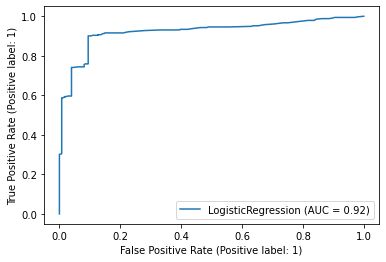

In [23]:
model_LR_disp = plot_roc_curve(model_LR, X_val, y_val)
plt.show()

### Evaluate LogReg: confusion matrix and AUC

In [24]:
print(f"Confusion Matrix: \n{confusion_matrix(y_val, ypred_LR)}")
print(f"Area Under Curve: {roc_auc_score(y_val, ypred_LR).round(2)}")
print(f"f1 - score: {f1_score(y_val, ypred_LR).round(2)}")

Confusion Matrix: 
[[453  76]
 [ 29 303]]
Area Under Curve: 0.88
f1 - score: 0.85


Interpretation:
- in contrast to the model LogReg model trained on all features, training the same one based on the most important features leads to clearly better results.
- re Confusion Matrix: out of 529 predictions regarding the positive class, 86% were predicted correctly. Out of 332 predictions regarding the negative class, 9% were predicted incorrectly (false negatives).
- f1 - score:  85%
- re AUC: the likelihood that a randomly selected customer from the minority group is scored higher than the a randomly selected customer from the majority group is 88% (vs. model trained on all features: 50%).

In [25]:
auc_LR = roc_auc_score(y_val, ypred_LR)
f1_LR = f1_score(y_val, ypred_LR)

In [26]:
train_accuracy = model_LR.score(X_train, y_train)
train_accuracy

0.8861458030787104

In [27]:
val_accuracy = model_LR.score(X_val, y_val)
val_accuracy

0.8780487804878049

=> while performance remains the same, with this dataset the model overfits less!

### Fit a Random Forest model

In [28]:
model_RF = RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=63, random_state=42) # params from manual tuning

In [29]:
X_train.copy()
y_train.copy()

Fecha Cierre
2018-07-31    0
2018-06-30    0
2018-07-31    0
2021-04-30    1
2019-01-31    1
             ..
2020-09-30    1
2018-02-28    1
2020-04-30    1
2021-02-28    1
2018-04-30    1
Name: Client_Status_Post3Months, Length: 3443, dtype: int64

In [30]:
model_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=63,
                       random_state=42)

### Make predictions.

In [31]:
ypred_RF = model_RF.predict(X_val)


In [32]:
probs_RF = model_RF.predict_proba(X_val) 
probs_RF

array([[0.93731377, 0.06268623],
       [0.        , 1.        ],
       [0.87257373, 0.12742627],
       ...,
       [0.95455118, 0.04544882],
       [0.        , 1.        ],
       [0.        , 1.        ]])

### Evaluate Random Forest: ROC curve 

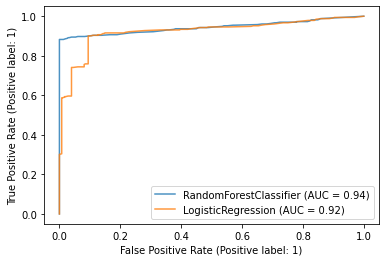

In [33]:
ax = plt.gca()

model_RF_disp = plot_roc_curve(model_RF, X_val, y_val, ax=ax, alpha=0.8)
model_LR_disp.plot(ax=ax, alpha=0.8)

plt.show() 

### Evaluate Random Forest: confusion matrix and AUC

In [34]:
print(f"Confusion Matrix: \n{confusion_matrix(y_val, ypred_RF)}")
print(f"Area Under Curve: {roc_auc_score(y_val, ypred_RF).round(2)}")
print(f"f1 - score: {f1_score(y_val, ypred_RF).round(2)}")

Confusion Matrix: 
[[529   0]
 [ 39 293]]
Area Under Curve: 0.94
f1 - score: 0.94


In [35]:
auc_RF = roc_auc_score(y_val, ypred_RF)
f1_RF = f1_score(y_val, ypred_RF)

Interpretation:
- re Confusion Matrix: out of 529 predictions regarding the positive class, 100% were predicted correctly. Model seems to be overfitting!
- Out of 332 predictions regarding the negative class, 12% were predicted incorrectly (false negatives).
- f1 - score:  94% (vs. initially 93%)
- re AUC: the likelihood that a randomly selected customer from the minority group is scored higher than the a randomly selected customer from the majority group is 94% - as in first version.

In [36]:
train_accuracy = model_RF.score(X_train, y_train)
train_accuracy

0.9648562300319489

In [37]:
val_accuracy = model_RF.score(X_val, y_val)
val_accuracy

0.9547038327526133

=> reduction in overfitting!

### Fit a Decision Tree model

In [38]:
model_DT = DecisionTreeClassifier(max_depth=6, random_state=42) # param from manual tuning

In [39]:
X_train.copy()
y_train.copy()

Fecha Cierre
2018-07-31    0
2018-06-30    0
2018-07-31    0
2021-04-30    1
2019-01-31    1
             ..
2020-09-30    1
2018-02-28    1
2020-04-30    1
2021-02-28    1
2018-04-30    1
Name: Client_Status_Post3Months, Length: 3443, dtype: int64

In [40]:
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

### Make predictions.

In [41]:
ypred_DT = model_DT.predict(X_val)

In [42]:
probs_DT = model_DT.predict_proba(X_val)
probs_DT

array([[0.93478261, 0.06521739],
       [0.01856148, 0.98143852],
       [0.88495575, 0.11504425],
       ...,
       [0.95959596, 0.04040404],
       [0.01856148, 0.98143852],
       [0.01856148, 0.98143852]])

### Evaluate Decision Tree: ROC curve 

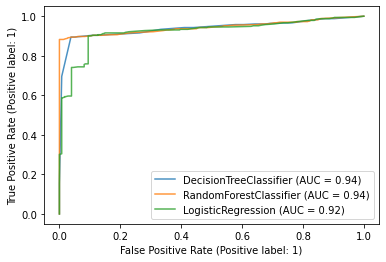

In [43]:
ax = plt.gca()

model_DT_disp = plot_roc_curve(model_DT, X_val, y_val, ax=ax, alpha=0.8)
model_RF_disp.plot(ax=ax, alpha=0.8)
model_LR_disp.plot(ax=ax, alpha=0.8)

plt.show()

### Evaluate Decision Tree: confusion matrix and AUC

In [44]:
print(f"Confusion Matrix: \n{confusion_matrix(y_val, ypred_DT)}")
print(f"Area Under Curve: {roc_auc_score(y_val, ypred_DT).round(2)}")
print(f"f1 - score: {f1_score(y_val, ypred_DT).round(2)}")

Confusion Matrix: 
[[509  20]
 [ 35 297]]
Area Under Curve: 0.93
f1 - score: 0.92


In [45]:
auc_DT = roc_auc_score(y_val, ypred_DT)
f1_DT = f1_score(y_val, ypred_DT)

Interpretation:
- re Confusion Matrix: out of 332 predictions regarding the positive class, 90% were predicted correctly. As such, DT shows best precision of all models. Out of 529 predictions regarding the negative class, 6% were predicted incorrectly (false negatives). 
- f1 - score = 89.95% 
- re AUC: the likelihood that a randomly selected customer from the minority group is scored higher than the a randomly selected customer from the majority group is 92% in the case of a Decision Tree classifier (vs. 94% of a Random Forest classifier).

In [46]:
train_accuracy = model_DT.score(X_train, y_train)
train_accuracy

0.9433633459192564

In [47]:
val_accuracy = model_DT.score(X_val, y_val)
val_accuracy

0.9361207897793263

=> reduction in overfitting!

### Summary model evaluation: AUC

In [48]:
auc = [["LogReg", auc_LR], ["Tree",  auc_DT], ["RF",  auc_RF]]
auc  = pd.DataFrame(auc , columns = ["Model", "auc"])
auc.sort_values(by=["auc"], inplace=True, ascending = False)
auc.set_index(["Model"])

,auc
Model,
RF,0.941265
Tree,0.928386
LogReg,0.884492


### Summary model evaluation: f1 - score

In [49]:
f1 = [["LogReg", f1_LR], ["Tree",  f1_DT], ["RF",  f1_RF]]
f1  = pd.DataFrame(f1 , columns = ["Model", "f1"])
f1.sort_values(by=["f1"], inplace=True, ascending = False)
f1.set_index(["Model"])

,f1
Model,
RF,0.937600
Tree,0.915254
LogReg,0.852321


#### Interpretation
* Random Forest Model shows best performance (based on AUC and f1-score).
* Both RF as well as Tree perform better than LogReg.
* All models tend to overfit less than with the complete dataset.
* LogReg suffers performance, in comparison with model trained on all features.

## Saving the Random Forest model.

In [50]:
with open("../artefacts/churn-model.bin", "wb") as f_out:
    pickle.dump(model_RF, f_out) 